In [1]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt

# This next command is specifically for Jupyter Notebook
%matplotlib notebook

pts = np.loadtxt('incomes.txt')

<IPython.core.display.Javascript object>


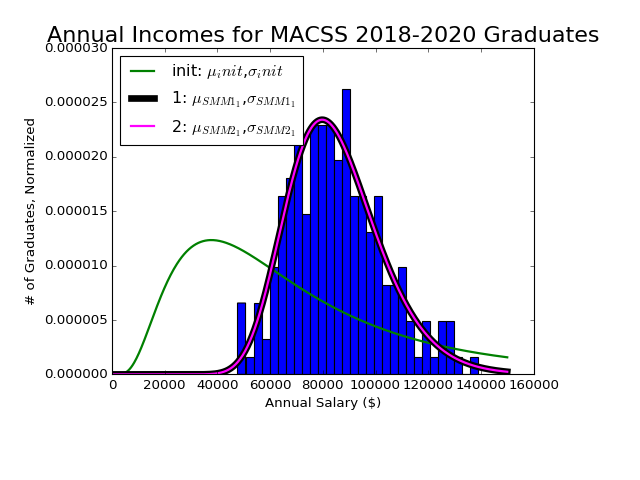

C:\cygwin64\home\Joanna\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: divide by zero encountered in true_divide
C:\cygwin64\home\Joanna\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: RuntimeWarning: divide by zero encountered in log
C:\cygwin64\home\Joanna\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: RuntimeWarning: invalid value encountered in multiply


In [155]:
fig, ax = plt.subplots(1, 1)

box = ax.get_position()
ax.set_position([box.x0+0.05, box.y0+0.12, box.width*0.85, box.height * 0.85])

count, bins, ignored = plt.hist(pts, 30, normed = True)

dist_pts = np.linspace(0, 150000, 500)

plt.plot(dist_pts, lognorm_pdf(dist_pts, 11, 0.68),
         linewidth=2, color='green', label='init: $\mu_init$,$\sigma_init$')
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_SMM1_1, sig_SMM1_1),
         linewidth=6, color='black', label='1: $\mu_{SMM1_1}$,$\sigma_{SMM1_1}$')
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_SMM2_1, sig_SMM2_1),
         linewidth=2, color='magenta', label='2: $\mu_{SMM2_1}$,$\sigma_{SMM2_1}$')
plt.legend(loc='upper left')

plt.title('Annual Incomes for MACSS 2018-2020 Graduates', fontsize=20)
plt.xlabel('Annual Salary ($)')
plt.ylabel('# of Graduates, Normalized')

In [170]:
def LN_pdf(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the lognormal pdf with mean mu and standard
    deviation sigma.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector or (N,S) array, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals = (N,) vector or (N,S) array lognormal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''

    pdf_vals = (1/(sigma * xvals * np.sqrt(2 * np.pi)) * 
                np.exp( -(np.log(xvals) - mu)**2 / (2 * sigma**2)))
    
    return pdf_vals

In [171]:
data = np.array([[200,270], [180, 195.5]])
data1 = np.array([201, 356])

pdf_vals = LN_pdf(data, 5, 1.0)
pdf_vals1 = LN_pdf(data1, 5, 1.0)
#print(pdf_vals1)
print(pdf_vals)

[[ 0.0019079   0.00123533]
 [ 0.00217547  0.0019646 ]]


In [51]:
# Define function that draws N x S test score values from a truncated
# normal distribution
def norm_draws(unif_vals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Draw (N x S) matrix of random draws from a lognormal distribution with 
    mean mu and standard deviation sigma. These draws correspond to an (N x S) 
    matrix of randomly generated draws from a uniform distribution U(0,1).
    --------------------------------------------------------------------
    INPUTS:
    unif_vals = (N, S) matrix, (N,) vector, or scalar in (0,1), random
                draws from uniform U(0,1) distribution
    mu        = scalar, mean of the nontruncated normal distribution
                from which the truncated normal is derived
    sigma     = scalar > 0, standard deviation of the nontruncated
                normal distribution from which the truncated normal is
                derived
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        scipy.stats.norm()
    
    OBJECTS CREATED WITHIN FUNCTION:
    unif2_vals  = (N, S) matrix, (N,) vector, or scalar in (0,1),
                  rescaled uniform derived from original.
    tnorm_draws = (N, S) matrix, (N,) vector, or scalar in (0,1),
                  values drawn from truncated normal PDF with base
                  normal distribution N(mu, sigma) and cutoffs
                  (cut_lb, cut_ub)
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: tnorm_draws
    --------------------------------------------------------------------
    '''
   
    norm_draws = sts.norm.ppf(unif_vals, loc=mu, scale=sigma)
    
    return norm_draws

In [53]:
mu_1 = 11
sig_1 = 0.68
np.random.seed(seed=1234)
unif_vals_1 = sts.uniform.rvs(0, 1, size=(300, 200))
draws_1 = norm_draws(unif_vals_1, mu_1, sig_1)
print('Mean score =', draws_1.mean())
print('Variance of scores =', draws_1.var())
print('Standard deviation of scores =', draws_1.std())
draws_1.shape

Mean score = 11.0034560411
Variance of scores = 0.463984536544
Standard deviation of scores = 0.681164103975


(300, 200)

In [54]:
sims = np.exp(draws_1)
sims

array([[  33084.78283312,   73976.01863553,   53821.14681278, ...,
          25347.61521902,  106733.44552213,  178111.79372919],
       [ 238784.61490958,  133678.7841051 ,   74718.99692823, ...,
         144559.84543613,   35902.85671552,   42256.19199366],
       [  88103.07932791,   89735.96320281,   14535.03880469, ...,
          68624.6075173 ,   73377.6839325 ,   31889.87540438],
       ..., 
       [ 130528.55144858,   68835.22224596,   47434.66732072, ...,
          39281.37935632,   29615.23040891,   55572.87581777],
       [ 182840.69184461,   74405.75928818,   25734.69598814, ...,
          13582.58632493,   89324.37933955,   47181.53628652],
       [ 103321.70921886,   82030.11930868,   56610.03159672, ...,
          86435.21894868,   18879.80152791,   67218.30390602]])

In [59]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for SMM
    (mean(data), variance(data)) from both the actual data and from the
    simulated data.
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N, S) matrix, (N,) vector, income data, "real" and simulated. 
            Real world data will come in the form (N,). Simulated data comes in the
            form (N,) or (N, S).
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar or (S,) vector, mean value of test scores data
    var_data  = scalar > 0 or (S,) vector, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    if xvals.ndim == 1:
        mean_data = xvals.mean()
        std_data = xvals.std()
    else:
        mean_data = xvals.mean(axis=0)
        std_data = xvals.std(axis=0)
    
    return mean_data, std_data

In [106]:
def err_vec(data_vals, sim_vals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for SMM.
    --------------------------------------------------------------------
    INPUTS:
    data_vals = (N,) vector, test scores data
    sim_vals  = (N, S) matrix, S simulations of test scores data
    mu        = scalar, mean of the nontruncated normal distribution
                from which the truncated normal is derived
    sigma     = scalar > 0, standard deviation of the nontruncated
                normal distribution from which the truncated normal is
                derived
    simple    = boolean, =True if errors are simple difference, =False
                if errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, estimated mean value from model
    var_model  = scalar > 0, estimated variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(data_vals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_sim, std_sim = data_moments(sim_vals)
    mean_model = mean_sim.mean()
    std_model = std_sim.mean()
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the SMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params    = (2,) vector, ([mu, sigma])
    mu        = scalar, mean of the normally distributed random variable
    sigma     = scalar > 0, standard deviation of the normally
                distributed random variable
    args      = length 3 tuple,
                (xvals, unif_vals, W_hat)
    xvals     = (N,) vector, values of the truncated normally
                distributed random variable
    unif_vals = (N, S) matrix, matrix of draws from U(0,1) distribution.
                This fixes the seed of the draws for the simulations
    W_hat     = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, unif_vals, W_hat = args
    sim_vals = np.exp(norm_draws(unif_vals, mu, sigma))
    err = err_vec(xvals, sim_vals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W_hat), err) 
    
    # These next two lines only get uncommented to diagnose a problem
    #print(mu, sigma)
    #print(err.reshape(2,))
    #print(sim_vals)
    
    return crit_val

In [150]:
mu_init_1 = 11
sig_init_1 = 0.68
np.random.seed(1234)
params_init_1 = np.array([mu_init_1, sig_init_1])
W_hat1_1 = np.eye(2)
unif_vals_2 = sts.uniform.rvs(0, 1, size=(300,200))
smm_args1_1 = (pts, unif_vals_2, W_hat1_1)
results1_1 = opt.minimize(criterion, params_init_1, args=(smm_args1_1),
                          method='L-BFGS-B', bounds = ((1e-10, None), (1e-10, None)))
                        #options={'eps': 0.2}, 
mu_SMM1_1, sig_SMM1_1 = results1_1.x
print('mu_SMM1_1=', mu_SMM1_1, ' sig_SMM1_1=', sig_SMM1_1)
print(results1_1)
#print(unif_vals_2)
#print(results1_1.hess_inv.todense())

mu_SMM1_1= 11.3306909515  sig_SMM1_1= 0.208983979199
      fun: array([[  6.63226968e-12]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  6.82622820e-06,   2.46880434e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 11
   status: 0
  success: True
        x: array([ 11.33069095,   0.20898398])


In [168]:
data_mean, data_std = data_moments(pts)
sims_mean, sims_std = data_moments(np.exp(norm_draws(unif_vals_2, mu_SMM1_1, sig_SMM1_1)))
mod_mean, mod_std = sims_mean.mean(), sims_std.mean()
print(data_mean, std_mean)
print(mod_mean, mod_std)

85276.8236063 17992.542128
85276.9133877 17992.5844156


In [160]:
sims = np.exp(norm_draws(unif_vals_2, mu_SMM1_1, sig_SMM1_1))
err2_1 = err_vec(pts, sims, mu_SMM1_1, sig_SMM1_1, False)
VCV2_1 = np.dot(err2_1, err2_1.T) / pts.shape[0]
print(VCV2_1)
W_hat2_1 = lin.pinv(VCV2_1)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2_1)
#print(sims)
#print(unif_vals_2)

[[  5.54218956e-15   1.23721709e-14]
 [  1.23721709e-14   2.76191589e-14]]
[[  5.03984306e+12   1.12507519e+13]
 [  1.12507519e+13   2.51157461e+13]]


In [152]:
np.random.seed(1234)
params_init_2 = np.array([mu_SMM1_1, sig_SMM1_1])
unif_vals_2 = sts.uniform.rvs(0, 1, size=(300,200))
smm_args2_1 = (pts, unif_vals_2, W_hat2_1)
results2_1 = opt.minimize(criterion, params_init_2, args=(smm_args2_1),
                          method='L-BFGS-B', bounds = ((1e-10, None), (1e-10, None)))#, options={'eps': 0.2})
mu_SMM2_1, sig_SMM2_1 = results2_1.x
print('mu_SMM2_1=', mu_SMM2_1, ' sig_SMM2_1=', sig_SMM2_1)
print(results2_1)
print(unif_vals_2)
#print(results2_1.hess_inv.todense())

mu_SMM2_1= 11.3306894993  sig_SMM2_1= 0.208983840826
      fun: array([[  1.45051222e-09]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  527123.78036245,  6784639.8124718 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 255
      nit: 5
   status: 0
  success: True
        x: array([ 11.3306895 ,   0.20898384])
[[ 0.19151945  0.62210877  0.43772774 ...,  0.10310444  0.80237418
   0.94555324]
 [ 0.97903882  0.88123225  0.62768192 ...,  0.90255503  0.22599553
   0.30415374]
 [ 0.71499388  0.72409148  0.01867644 ...,  0.57949344  0.61756091
   0.17711749]
 ..., 
 [ 0.87412289  0.58125464  0.36599209 ...,  0.26768015  0.15028091
   0.45635078]
 [ 0.94967612  0.62534226  0.10716045 ...,  0.01457126  0.72182749
   0.36303577]
 [ 0.78882677  0.67831875  0.46714882 ...,  0.70537638  0.04482164
   0.56755326]]
